In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
import scipy

In [2]:
# project files

from utils.variables import pack, unpack
from utils.display import table, tabulate
from utils.files import download_sheet, save, load
from utils.hash import digest

from fit_options import fit_options
from game_model import game
from rp_model import compute_rp, make_precomputed_columns
from initial_guess import make_initial_guess

In [3]:
# stuff for display

from IPython.lib.pretty import pretty, pprint

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [4]:
data = pd.read_pickle(fit_options.data_file)
data.describe()
data.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,FreqL,Inv,Berry1,BerryL,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,BerryD,IngD,Dupes,Amnt,Ing2P,Help skill bonus,RP Multiplier
count,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.0,6298.000000,6298.000000,6298.000000,6298.000000
mean,10.568752,604.277072,1.491426,604.317798,0.040726,3958.844077,3809.132584,12.221340,28.044776,37.712925,108.864560,1.017633,0.988404,0.994754,1.001207,1.005176,0.207796,32.639038,55.126548,148.948079,1.0,0.072721,2.975707,0.987685,1.027737
std,7.138779,389.355772,0.983268,389.410942,0.960091,962.872171,1024.241487,3.383991,2.609196,8.009850,16.016822,0.303905,0.059301,0.045062,0.117886,0.118129,0.044898,36.128194,27.676665,60.660176,0.0,0.512616,20.491814,0.037644,0.069859
min,1.000000,245.000000,1.000000,245.060000,-11.980000,2200.000000,1489.118400,7.000000,24.000000,24.000000,90.000000,0.520000,0.890000,0.920000,0.800000,0.800000,0.130000,5.880000,25.000000,90.000000,1.0,0.000000,0.000000,0.790000,1.000000
25%,5.000000,354.000000,1.000000,354.267500,-0.280000,3300.000000,2953.125000,10.000000,26.000000,32.000000,98.000000,0.800000,1.000000,1.000000,1.000000,1.000000,0.180000,12.810000,35.000000,101.000000,1.0,0.000000,0.000000,1.000000,1.000000
50%,10.000000,460.000000,1.000000,459.935000,-0.010000,3900.000000,3794.350000,12.000000,28.000000,36.000000,103.000000,0.940000,1.000000,1.000000,1.000000,1.000000,0.200000,19.980000,45.000000,121.000000,1.0,0.000000,0.000000,1.000000,1.000000
75%,14.000000,711.750000,2.000000,711.607500,0.270000,4500.000000,4455.000000,14.000000,31.000000,42.000000,115.000000,1.210000,1.000000,1.000000,1.000000,1.000000,0.240000,43.980000,68.000000,202.000000,1.0,0.000000,0.000000,1.000000,1.000000
max,42.000000,3440.000000,6.000000,3440.430000,10.460000,6300.000000,6916.140000,23.000000,35.000000,77.000000,151.000000,2.410000,1.120000,1.080000,1.200000,1.200000,0.420000,413.950000,222.000000,511.000000,1.0,8.000000,342.000000,1.000000,1.440000


,Pokemon,Level,RP,Nature,MS lvl,Source,ModelRP,Difference,Nature2,ID,NatureP,NatureN,Freq1,FreqL,Type,Class,MSkill,Inv,Berry1,BerryL,Ing1,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,RPneutral,IDNeutral,BerryD,IngD,Dupes,DupeMatch,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,Help skill bonus,RP Multiplier
0,Arbok,9.0,574.0,Naughty,1.0,Rate My Mon,574.42,0.42,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,3700.0,3276.72,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,1.09,0.90,1.00,1.0,0.8,0.26,22.76,538.36,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
1,Arbok,8.0,531.0,Hardy,1.0,Questions help guides,530.70,-0.30,Neutral,ArbokNeutral81,-,-,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.0,1.0,0.26,22.76,531.00,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
2,Arbok,8.0,538.0,Quiet,1.0,Questions help guides,538.09,0.09,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.2,1.0,0.26,22.76,530.61,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
3,Arcanine,5.0,958.0,Calm,3.0,,957.90,-0.10,Calm,ArcanineCalm53,Main Skill Chance,Speed of Help,2500.0,2728.00,Fire,Skills,Extra Helpful S,16.0,27.0,31,Fiery Herb,130.0,1.31,1.11,1.00,1.0,1.2,0.14,84.50,937.84,ArcanineNeutral53,31.0,130.0,1,True,,,,0.0,0.0,1.0,1.0
4,Arcanine,3.0,715.0,Lax,2.0,pokemon sleep general,714.77,-0.23,Lax,ArcanineLax32,Energy Recovery,Main Skill Chance,2500.0,2490.00,Fire,Skills,Extra Helpful S,16.0,27.0,29,Fiery Herb,130.0,1.44,1.00,1.08,1.0,0.8,0.14,61.21,750.21,ArcanineNeutral32,29.0,130.0,1,True,,,,0.0,0.0,1.0,1.0


In [5]:
# Make an initial guess
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector

x0, unpack_info = pack(make_initial_guess())
computed = make_precomputed_columns(data)

In [6]:
# We compute the RP model in rp_model.py
# Here we create closure to glue the pieces together.

def RP(x):
    return compute_rp(x, data, computed, unpack_info)

def residual(x):
    return data["RP"] - RP(x)


In [7]:
filename = fit_options.result_file(digest(data, x0))
opt = load(filename)
sol = unpack(opt.x, unpack_info)

opt

    message: `ftol` termination condition is satisfied.
    success: True
     status: 2
          x: [ 2.566e-01  2.547e-01 ...  2.200e-01  9.939e-01]
       cost: 731.1402517870247
       grad: [ 1.288e-05  2.205e-06 ...  0.000e+00  2.374e-05]
 optimality: 0.04451485816389322
       nfev: 46
       njev: 28

In [8]:
# What are the worst points?

df = data[["Pokemon","ID","Level","Class","Inv","MS lvl","NatureP","NatureN","Sub Skill 1","Sub Skill 2","RP"]].copy()

df["fit"] = RP(opt.x)
df["error"] = residual(opt.x)
df["error2"] = df["error"]**2

df = df.sort_values("error2", ascending = False)
df.head(100)

,Pokemon,ID,Level,Class,Inv,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
1234,Gengar,GengarMild303Inventory Up MSleep EXP Bonus,30.0,Ingredients,18.0,3.0,Ingredient Finding,Energy Recovery,Inventory Up M,Sleep EXP Bonus,1904.0,1888.068969,15.931031,253.797740
2159,Raichu,RaichuLonely302Inventory Up MHelping bonus,30.0,Berries,21.0,2.0,Speed of Help,Energy Recovery,Inventory Up M,Helping bonus,1754.0,1740.569124,13.430876,180.388442
2801,Victreebel,VictreebelNeutral313Energy Recovery BonusInven...,31.0,Ingredients,17.0,3.0,-,-,Energy Recovery Bonus,Inventory Up M,1713.0,1699.739140,13.260860,175.850407
2802,Victreebel,VictreebelNeutral323Energy Recovery BonusInven...,32.0,Ingredients,17.0,3.0,-,-,Energy Recovery Bonus,Inventory Up M,1751.0,1737.946454,13.053546,170.395056
2158,Raichu,RaichuLonely264Skill Level Up MInventory Up M,26.0,Berries,21.0,4.0,Speed of Help,Energy Recovery,Skill Level Up M,Inventory Up M,1356.0,1343.278348,12.721652,161.840434
2803,Victreebel,VictreebelNeutral333Energy Recovery BonusInven...,33.0,Ingredients,17.0,3.0,-,-,Energy Recovery Bonus,Inventory Up M,1769.0,1756.852627,12.147373,147.558675
1401,Haunter,HaunterMild302Inventory Up MSleep EXP Bonus,30.0,Ingredients,14.0,2.0,Ingredient Finding,Energy Recovery,Inventory Up M,Sleep EXP Bonus,1327.0,1316.547945,10.452055,109.245461
2205,Raticate,RaticateBrave301Inventory Up MSleep EXP Bonus,30.0,Berries,16.0,1.0,Speed of Help,EXP Gains,Inventory Up M,Sleep EXP Bonus,1250.0,1240.942941,9.057059,82.030320
2603,Togekiss,TogekissGentle103Skill Trigger M,10.0,Skills,16.0,3.0,Main Skill Chance,Energy Recovery,Skill Trigger M,,1282.0,1272.965167,9.034833,81.628202
2727,Typhlosion,TyphlosionCareful273Berry Finding SHelping Spe...,27.0,Berries,23.0,3.0,Main Skill Chance,Ingredient Finding,Berry Finding S,Helping Speed M,1761.0,1752.286672,8.713328,75.922086


intercept,-0.0353451
intercept_stderr,0.0184169
pvalue,3.94087e-10
rvalue,0.0787284
slope,0.009049
stderr,0.00144406


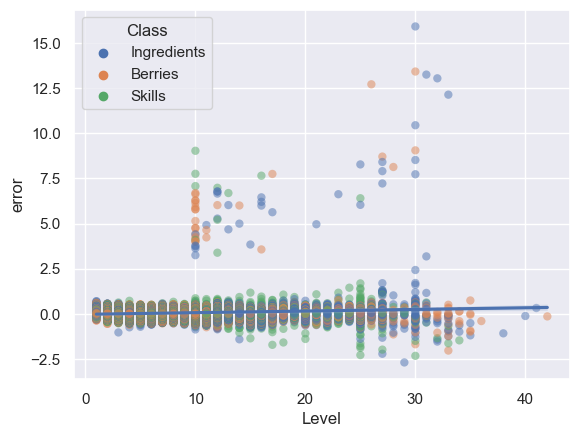

In [9]:
# Plot error vs level

err = df[["Level","error","Class"]]
palette = sns.color_palette(n_colors=3)

_ = sns.scatterplot(data=err, x="Level", y="error", hue="Class", alpha=0.5, linewidth=0, palette=palette)
_ = sns.regplot(data=err, x="Level", y="error", scatter=False)

# What is the slope ?
linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

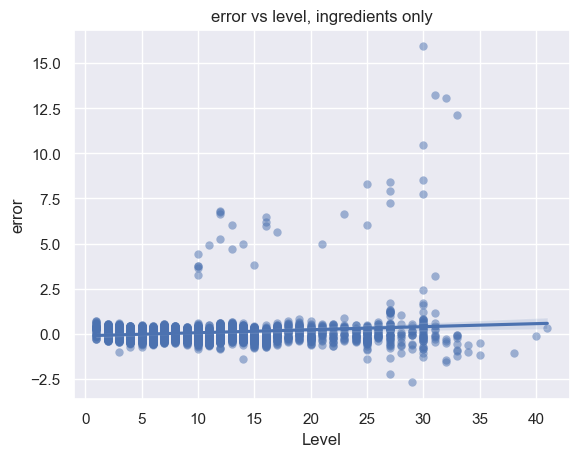

In [10]:
err2 = err[ err["Class"]=="Ingredients" ]
p = sns.scatterplot(data=err2, x="Level", y="error", alpha=0.5, linewidth=0, color=palette[0])
_ = sns.regplot(data=err2, x="Level", y="error", scatter=False)
_ = p.set(title='error vs level, ingredients only')


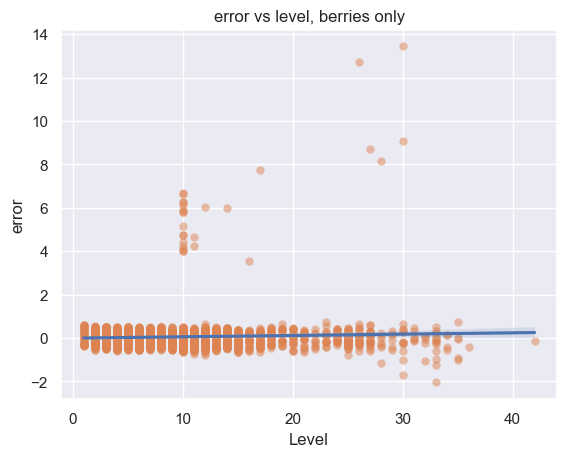

In [11]:
err2 = err[ err["Class"]=="Berries" ]
p = sns.scatterplot(data=err2, x="Level", y="error", alpha=0.5, linewidth=0, color=palette[1])
_ = sns.regplot(data=err2, x="Level", y="error", scatter=False)
_ = p.set(title='error vs level, berries only')

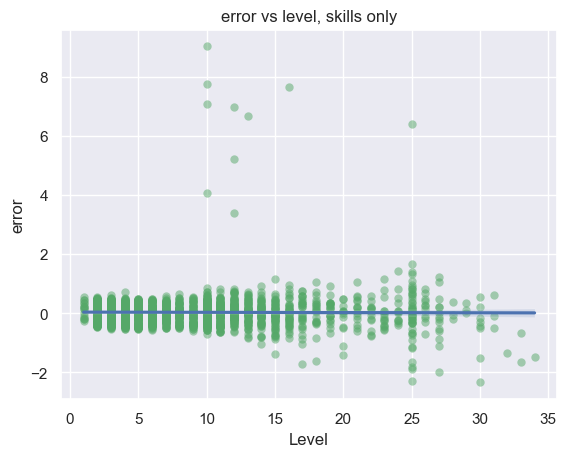

In [12]:
err2 = err[ err["Class"]=="Skills" ]

p = sns.scatterplot(data=err2, x="Level", y="error", alpha=0.5, linewidth=0, color=palette[2])
_ = sns.regplot(data=err2, x="Level", y="error", scatter=False)
_ = p.set(title='error vs level, skills only')


intercept,-0.0443004
intercept_stderr,0.0154494
pvalue,7.60128e-08
rvalue,0.0794084
slope,0.00905244
stderr,0.001681


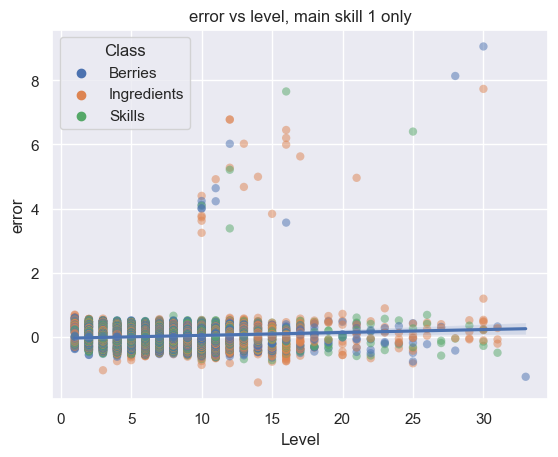

In [13]:
# Plot error vs level - focus on main skill 1

err = df[["Level","error","Class"]].loc[df["MS lvl"]==1]

p = sns.scatterplot(data=err, x="Level", y="error", hue="Class", alpha=0.5, linewidth=0)
_ = sns.regplot(data=err, x="Level", y="error", scatter=False)

_ = p.set(title='error vs level, main skill 1 only')

# What is the slope ?
linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

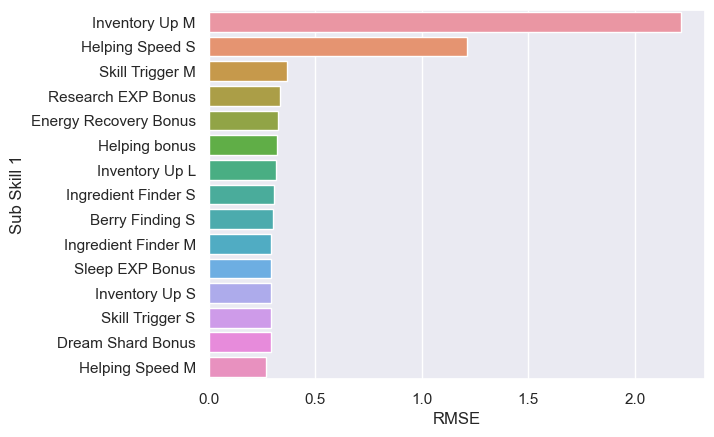

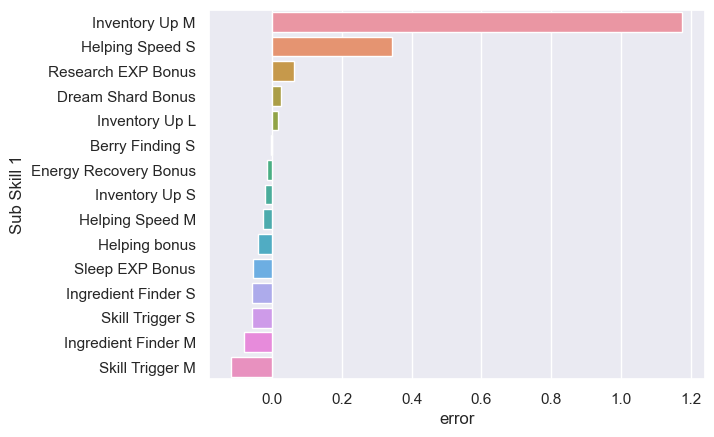

In [14]:
# Let's see what happens at level 10 and main skill 1

subskill_err = ( df[["Level", "Sub Skill 1", "error", "error2"]].loc[ (df["Level"]==10) & (df["MS lvl"]==1) ]
                .groupby("Sub Skill 1")
                .mean()
                .sort_values("error2", ascending = False)
                .reset_index() )

subskill_err["RMSE"] = np.sqrt(subskill_err["error2"])

_ = plt.figure()
_ = sns.barplot(data=subskill_err, y="Sub Skill 1", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=subskill_err.sort_values("error", ascending = False), y="Sub Skill 1", x="error")


intercept,-0.0443004
intercept_stderr,0.0154494
pvalue,7.60128e-08
rvalue,0.0794084
slope,0.00905244
stderr,0.001681


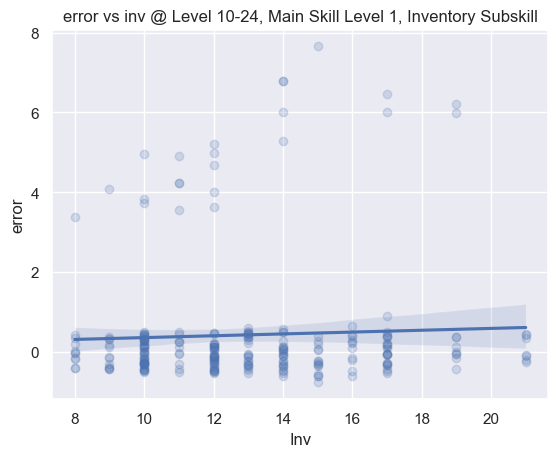

In [15]:
# Let's see what happens at level 10-24, main skill 1, and inventory bonus 

inventory_err = ( df[["Level", "Inv", "Sub Skill 1", "error", "error2"]] 
                 .loc[ (df["Level"]<25) & (df["MS lvl"]==1) & ( df["Sub Skill 1"].str.contains("Inventory")) ]
                )

p = sns.regplot(data=inventory_err, x="Inv", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

_ = p.set(title='error vs inv @ Level 10-24, Main Skill Level 1, Inventory Subskill')

linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

intercept,-0.0443004
intercept_stderr,0.0154494
pvalue,7.60128e-08
rvalue,0.0794084
slope,0.00905244
stderr,0.001681


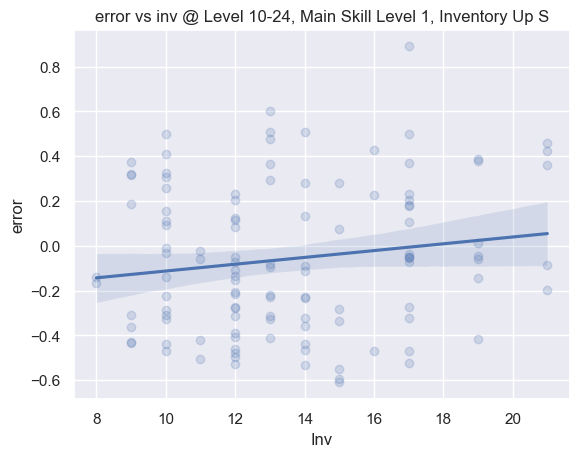

In [16]:
# Let's see what happens at level 10-24, main skill 1, and inventory bonus

inventory_err = ( df[["Level", "Inv", "Sub Skill 1", "error", "error2"]]
                 .loc[ (df["Level"]<25) & (df["MS lvl"]==1) & ( df["Sub Skill 1"] == "Inventory Up S" ) ]
                )

p = sns.regplot(data=inventory_err, x="Inv", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

_ = p.set(title='error vs inv @ Level 10-24, Main Skill Level 1, Inventory Up S')

linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

intercept,-0.0443004
intercept_stderr,0.0154494
pvalue,7.60128e-08
rvalue,0.0794084
slope,0.00905244
stderr,0.001681


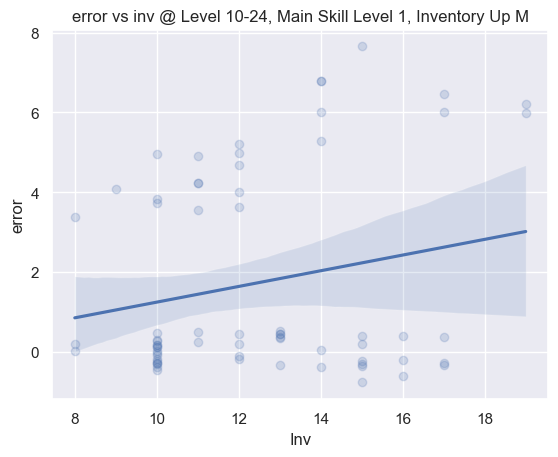

In [17]:
# Let's see what happens at level 10-24, main skill 1, and inventory bonus

inventory_err = ( df[["Level", "Inv", "Sub Skill 1", "error", "error2"]]
                 .loc[ (df["Level"]<25) & (df["MS lvl"]==1) & ( df["Sub Skill 1"] == "Inventory Up M" ) ]
                )

p = sns.regplot(data=inventory_err, x="Inv", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

_ = p.set(title='error vs inv @ Level 10-24, Main Skill Level 1, Inventory Up M')

linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

In [18]:
df[["Level", "Inv","NatureP","NatureN", "Sub Skill 1", "error", "error2"]].loc[ (df["Level"]<25) & (df["MS lvl"]==1) & ( df["Sub Skill 1"] == "Inventory Up M" )  & (df["error2"] > 1)]


,Level,Inv,NatureP,NatureN,Sub Skill 1,error,error2
1430,16.0,15.0,Speed of Help,Energy Recovery,Inventory Up M,7.653266,58.572487
18,12.0,14.0,Speed of Help,Energy Recovery,Inventory Up M,6.780407,45.973915
2885,12.0,14.0,Speed of Help,Energy Recovery,Inventory Up M,6.775522,45.907695
2804,16.0,17.0,Energy Recovery,EXP Gains,Inventory Up M,6.451759,41.625199
2026,16.0,19.0,Energy Recovery,Ingredient Finding,Inventory Up M,6.203884,38.488174
2876,13.0,14.0,EXP Gains,Energy Recovery,Inventory Up M,6.023612,36.283901
1935,12.0,17.0,Ingredient Finding,Energy Recovery,Inventory Up M,6.021703,36.260913
2027,16.0,19.0,Energy Recovery,Main Skill Chance,Inventory Up M,5.994996,35.939981
2883,12.0,14.0,Energy Recovery,Main Skill Chance,Inventory Up M,5.274677,27.822217
1036,12.0,12.0,Speed of Help,Energy Recovery,Inventory Up M,5.211744,27.162280


intercept,-0.0443004
intercept_stderr,0.0154494
pvalue,7.60128e-08
rvalue,0.0794084
slope,0.00905244
stderr,0.001681


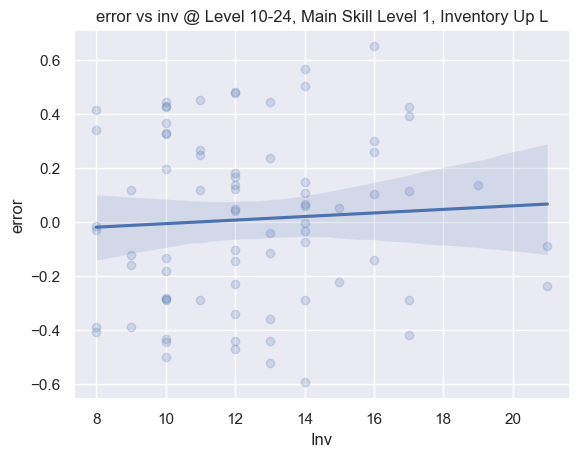

In [19]:
# Let's see what happens at level 10-24, main skill 1, and inventory bonus

inventory_err = ( df[["Level", "Inv", "Sub Skill 1", "error", "error2"]]
                 .loc[ (df["Level"]<25) & (df["MS lvl"]==1) & ( df["Sub Skill 1"] == "Inventory Up L" ) ]
                )

p = sns.regplot(data=inventory_err, x="Inv", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

_ = p.set(title='error vs inv @ Level 10-24, Main Skill Level 1, Inventory Up L')

linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

[Text(0.5, 1.0, 'error vs inv @ Level 10-24, Main Skill Level 1, Not Inventory Subskill')]

intercept,-0.0443004
intercept_stderr,0.0154494
pvalue,7.60128e-08
rvalue,0.0794084
slope,0.00905244
stderr,0.001681


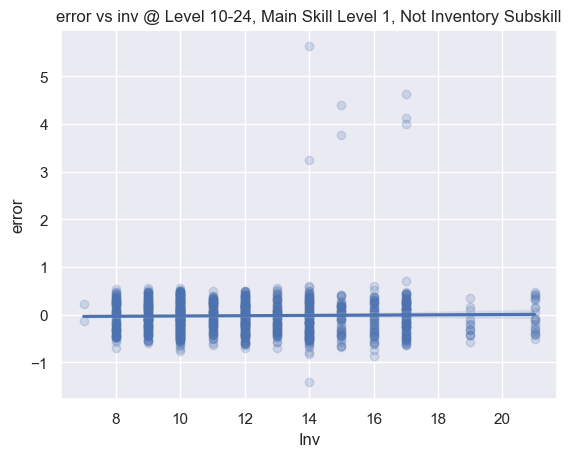

In [20]:
# Let's see what happens at level 10-24, main skill 1, and not inventory bonus 

inventory_err = ( df[["Level", "Inv", "Sub Skill 1", "error", "error2"]] 
                 .loc[ (df["Level"]>9) & (df["Level"]<25) & (df["MS lvl"]==1) & ( ~df["Sub Skill 1"].str.contains("Inventory") ) ]
                )

p = sns.regplot(data=inventory_err, x="Inv", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

p.set(title='error vs inv @ Level 10-24, Main Skill Level 1, Not Inventory Subskill')

linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

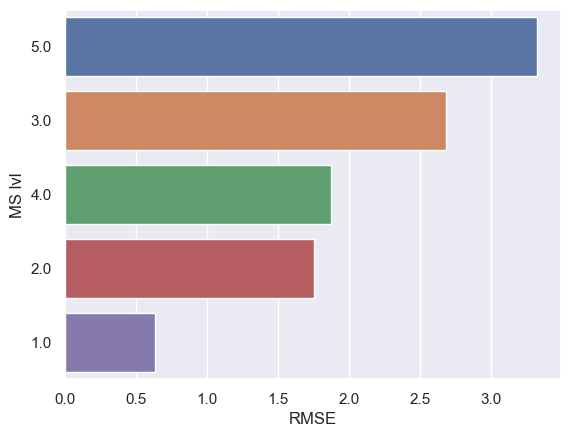

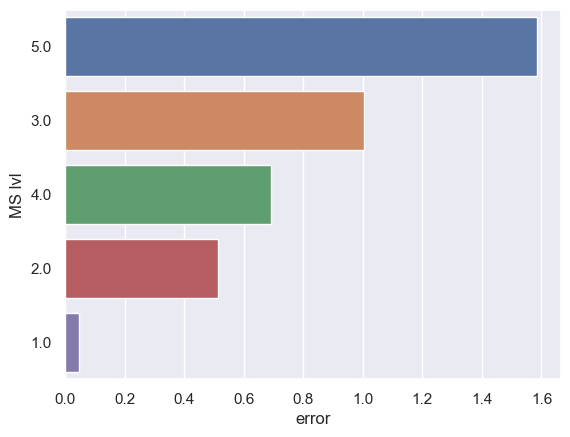

In [21]:
mslvl_err = ( df[["Level", "MS lvl", "error", "error2"]][df["Level"]==10]
                .groupby("MS lvl")
                .mean()
                .sort_values("error2", ascending = False)
                .reset_index() )

mslvl_err["RMSE"] = np.sqrt(mslvl_err["error2"])
mslvl_err["MS lvl"] = mslvl_err["MS lvl"].astype(str)

_ = plt.figure()
_ = sns.barplot(data=mslvl_err, y="MS lvl", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=mslvl_err.sort_values("error", ascending = False), y="MS lvl", x="error")


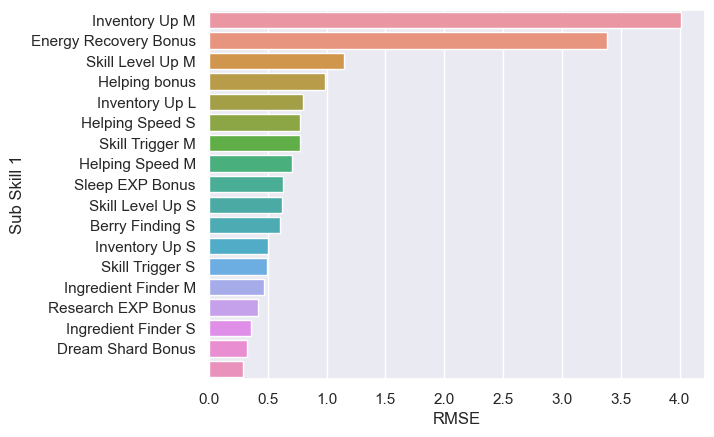

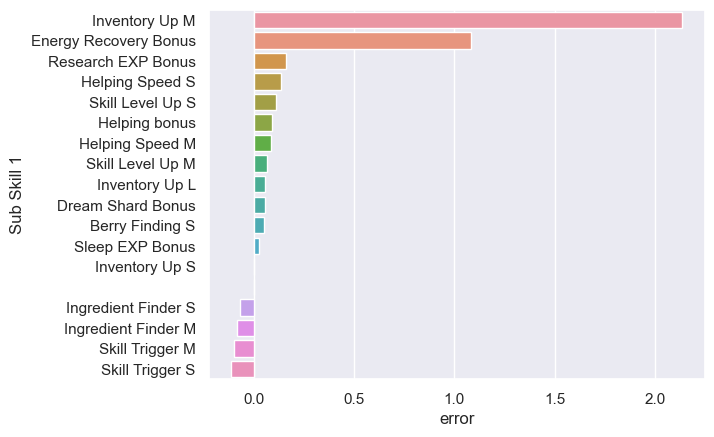

In [22]:
# Do we have more error in some skills ?

errorbyskill1 = (df[["Sub Skill 1","error","error2"]]
                .groupby("Sub Skill 1")
                .mean()
                .sort_values("error2", ascending = False)
                #.rename(columns={"error":"avg abs error"})
                .reset_index() )

errorbyskill1["RMSE"] = np.sqrt(errorbyskill1["error2"])
    
_ = plt.figure()
_ = sns.barplot(data=errorbyskill1, y="Sub Skill 1", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=errorbyskill1.sort_values("error", ascending = False), y="Sub Skill 1", x="error")

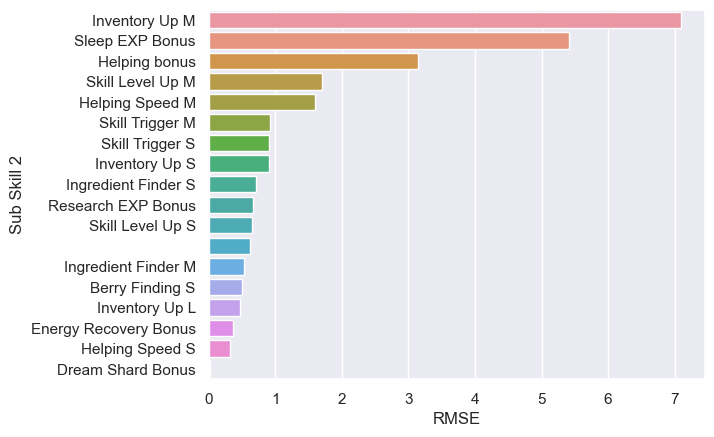

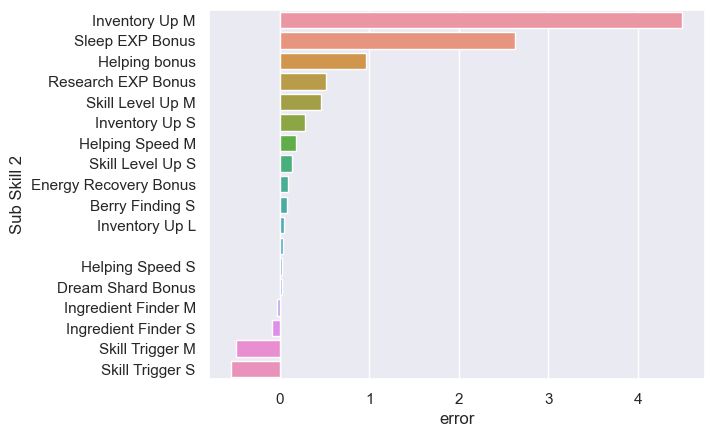

In [23]:
errorbyskill2 = (df[["Sub Skill 2","error","error2"]]
                .groupby("Sub Skill 2")
                .mean()
                .sort_values("error2", ascending = False)
                #.rename(columns={"error":"avg abs error"})
                .reset_index() )

errorbyskill2["RMSE"] = np.sqrt(errorbyskill2["error2"])
    
_ = plt.figure()
_ = sns.barplot(data=errorbyskill2, y="Sub Skill 2", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=errorbyskill2.sort_values("error", ascending = False), y="Sub Skill 2", x="error")